# Examen Python data developer
# Deel 1
## Introductie
Voor dit examen is het belangrijk dat je volgende zaken zeker doet:
 - Maak een Vitual Environment aan & exporteer een `.yml` (of soortgelijke) file aan die je toevoegt aan je codebase.
 - Maak een github pagina aan met een bijhorende `.gitignore` en `readme.md`. Voeg een link naar de github repo toe aan je readme file.
 - Zorg dat je op het einde de tijd neemt om je code op te schonen zodat deze begrijpelijk is voor derden.
 - Wanneer je klaar bent, maak een `.zip` bestand van je volledige codebase aan en laad deze op in de leeromgeving.

In deze opgave bekijken we een gesimuleerde dataset over de geboortes in België van 2019. De data is te vinden in `.csv` bestanden die gelabeld zijn met de echte geboortedag van de personen in het bestand. Laat ons bijvoorbeeld even kijken naar de eerste 5 lijnen van het bestand `2019-1-1.csv`:

<table align="center">
  <tr>
    <th>gemeente</th>
    <th>naam</th>
    <th>geslacht</th>
    <th>verwachte datum</th>
  </tr>
  <tr>
    <td>Hooglede</td>
    <td>Elias</td>
    <td>Mannelijk</td>
    <td>01/14/2019</td>
  </tr>
  <tr>
    <td>Sint-Niklaas (Sint-Niklaas)</td>
    <td>Pauline</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Wijnegem</td>
    <td>Anita</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Grâce-Hollogne</td>
    <td>Jean-Paul</td>
    <td>Mannelijk</td>
    <td>01/13/2019</td>
  </tr>
  <tr>
    <td>Boussu</td>
    <td>François</td>
    <td>Mannelijk</td>
    <td>01/26/2019</td>
  </tr>
</table>


Hier hebben we de kolommen:
 - **gemeente**: De gemeente waar de persoon geboren is.
 - **naam**: De voornaam van de persoon.
 - **geslacht**: Het geslacht van de persoon (Mannelijk of Vrouwelijk).
 - **verwachte datum**: De verwachte geboortedatum van de persoon.

Dus hier hebben we dan bijvoorbeeld op de eerste lijn de mannelijke persoon Elias die geboren is in Hooglede waarvan men verwachtte dat hij zou geboren worden op `01/14/2019` (Amerikaans formaat) maar in feite geboren is op 1 januari 2019.

Doorheen deze opgave gaan we de data van dichterbij inspecteren! Je kan deze opgaves alternatief lezen in de bijgeleverde notebook `examen.ipynb` waar ook de (meeste) afbeeldingen & resultaten zichtbaar zijn.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Custom scripts
sys.path.append('../scripts')  # Adjust the path accordingly
from read_data import read_csv_files
from make_a_chart import lineplot
from make_a_chart import barplot
from make_a_chart import horizontal_bar_plot
from make_a_chart import histogram_plot
from outliers import calculate_wrong_outliers
from outliers import handle_wrong_outliers
from outliers import calculate_other_outliers
from calculate_unisex import most_popular_name_and_count

# Define data locatons
rootdir = os.path.join(os.getcwd(), '../')
input_path = os.path.join(rootdir, 'data', 'input')
output_path = os.path.join(rootdir, 'data', 'output')

## Utilities

In [2]:
def to_percentage(number):
    return str(np.round(number * 100, 2)) + "%"

def compute_num_unique(df, n_births):
    return len(np.unique(df['naam'].sample(n_births)))

## Stap 1: data inlezen

Maak een lus over alle bestanden in de map `data/geboortes`, lees elk `.csv` bestand in en voeg deze samen tot 1 grote DataFrame. Merk op dat de datum verwerkt zit in de filename, voeg deze toe aan de kleine DataFrames voor je de dataframes samenvoegt met een `pd.concat(dfs)`.

Voeg een extra kolom toe met een `"dag van het jaar"` getal, dus 1 januari 2019 is `1`, 2 januari 2019 is `2`, enzovoort.

**Opmerking**: Er is ook data voor 29 februari 2019, terwijl dit geen schrikkeljaar is! Plaats deze geboortes in een afzonderlijke DataFrame `df_wrong`. Zet in `df_wrong` een extra kolom met een referentie naar waarom deze data foutief is.

In [3]:
# Read all .csv files, put them in a df, add (and rename) the column "dag geboorte"
births_df_raw = (read_csv_files(input_path)
                 .rename(columns={'file_name': 'dag geboorte'}))

# Put 2019-2-29 in df_wrong, keep other records in births_df_raw and rename to births_df
df_wrong = births_df_raw[births_df_raw['dag geboorte'] == "2019-2-29"].copy()
df_wrong["reden foutief"] = "Onbestaande geboortedag"
births_df = births_df_raw[births_df_raw['dag geboorte'] != "2019-2-29"]

### Data quality checks

In [4]:
births_df.describe()

,gemeente,naam,geslacht,verwachte datum,dag geboorte
count,116850,116850,116850,116850,116850
unique,579,5255,2,427,365
top,Antwerpen,Maria,Mannelijk,07/06/2019,2019-7-1
freq,6051,1627,58932,399,923


In [5]:
births_df.dtypes

gemeente           object
naam               object
geslacht           object
verwachte datum    object
dag geboorte       object
dtype: object

In [6]:
births_df.isnull().sum()

gemeente           0
naam               0
geslacht           0
verwachte datum    0
dag geboorte       0
dtype: int64

### Omzetten naar datetimes & toevoegen "dag van het jaar"

Vooraleer we 'dag van het jaar' kunnen toevoegen, moeten we datums eerst omzetten naar datetimes.

In [7]:
# Convert strings to datetimes
births_df.loc[:, 'verwachte datum'] = pd.to_datetime(births_df['verwachte datum'], format='%m/%d/%Y')
births_df.loc[:, 'dag geboorte'] = pd.to_datetime(births_df['dag geboorte'], format='%Y-%m-%d')

# Check the data types of the columns after conversion
print("Data types of columns in the combined DataFrame after conversion:")
print(births_df.dtypes)

Data types of columns in the combined DataFrame after conversion:
gemeente           object
naam               object
geslacht           object
verwachte datum    object
dag geboorte       object
dtype: object


### Kopieer dataframe en voeg extra kolommen toe

In [8]:
# Take a copy of the original DataFrame
births_xtracols_df = births_df.copy()

# Change column names for simplicity and consistency
births_xtracols_df = births_xtracols_df.rename(columns={"verwachte datum": "datum_verwacht", "dag geboorte": "datum_geboorte"})

# Convert columns to datetime if they are not already
births_xtracols_df['datum_verwacht'] = pd.to_datetime(births_xtracols_df['datum_verwacht'], format='%m/%d/%Y')
births_xtracols_df['datum_geboorte'] = pd.to_datetime(births_xtracols_df['datum_geboorte'], format='%Y-%m-%d')

# Add new columns to the DataFrame for easier future calculations
births_xtracols_df['weekdag_verwacht'] = births_xtracols_df['datum_verwacht'].dt.day_name()
births_xtracols_df['weekdag_geboorte'] = births_xtracols_df['datum_geboorte'].dt.day_name()
births_xtracols_df['dag_verwacht'] = births_xtracols_df['datum_verwacht'].dt.dayofyear
births_xtracols_df['dag_geboorte'] = births_xtracols_df['datum_geboorte'].dt.dayofyear  # "dag van het jaar"
births_xtracols_df['verschil'] = (births_xtracols_df['datum_geboorte'] - births_xtracols_df['datum_verwacht']).dt.days

# Let's sort on 'dag van het jaar'
births_xtracols_df.sort_values(by='dag_geboorte', ascending=True, inplace=True)
births_xtracols_df.reset_index(drop=True, inplace=True)

## Stap 2: Dagelijks aantal geboortes bekijken
#### Vraag 1: Maak een plot van het aantal geboortes per dag van het jaar. 

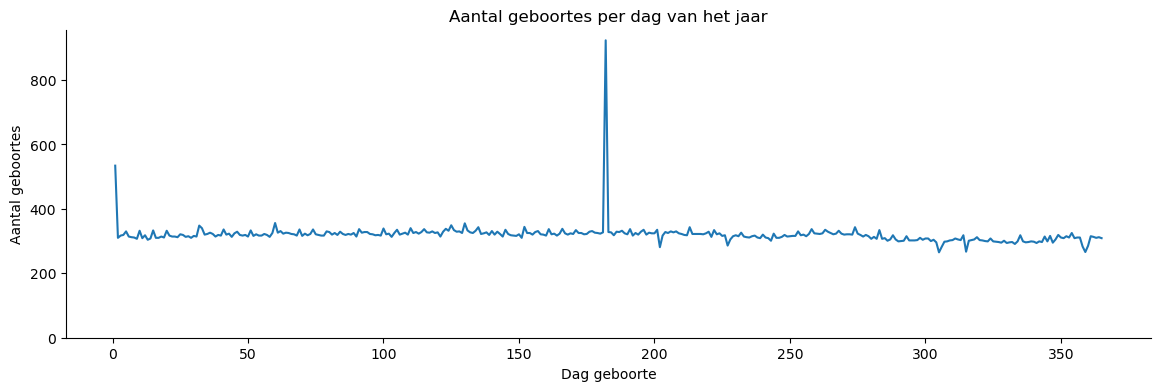

In [9]:
# Grouping by 'dag_geboorte' and counting the number of occurrences
births_per_day = (births_xtracols_df
                  .groupby('dag_geboorte')
                  .size())

# Create a lineplot
lineplot(births_per_day,
         title='Aantal geboortes per dag van het jaar',
         x_label='Dag geboorte',
         y_label='Aantal geboortes',
         set_ylim=0)

#### Vraag 2: Outliers vinden & behandelen

We klassificeren een datum als een outlier als het aantal geboortes meer dan `50%` afwijkt van de gemiddelde waarde overheen de volledige dataset. Zoek alle outliers in de dataset.

Ik zal je vertellen; de outliers op 1 januari en 1 juli komen doordat alle geboortes waarvoor de datum niet correct genoteerd is, de datum 1 januari (voor de eerste helft van het jaar) en op 1 juli (voor de tweede helft van het jaar) geplaatst worden. Om dit op te lossen, halen we in de grote geboortes DataFrame (met 1 lijn per geboorte) deze twee datums er volledig uit. Dus we gaan **alle** geboortes van 1 januari en 1 juli verwijderen uit deze dataframe en toevoegen aan de `df_wrong` dataframe met als reden `2019-01-01` en `2019-07-01`.

In [10]:
# Calculate outliers
outliers = (calculate_wrong_outliers(births_per_day)
            .reset_index()
            .rename(columns={0: "aantal geboortes"}))
print(f"\n{outliers}")

# Handle outliers
births_xtracols_cleaned_df, df_wrong_extended = handle_wrong_outliers(data=births_xtracols_df,
                                                                outliers=outliers["dag_geboorte"],
                                                                reason="Datum geboorte",
                                                                df_wrong=df_wrong)

df_wrong_extended.drop(columns=['weekdag_verwacht', 'weekdag_geboorte', 'dag_verwacht', 'verschil'], inplace=True)
df_wrong_extended.sample(10)

Gemiddeld aantal geboortes per dag: 320.1
Lower outlier threshold: 160.1 ; Upper outlier threshold: 480.2

   dag_geboorte  aantal geboortes
0             1               534
1           182               923


,gemeente,naam,geslacht,verwachte datum,dag geboorte,reden foutief,datum_verwacht,datum_geboorte
462,Hannuit,Victoria,Vrouwelijk,NaN,NaN,Datum geboorte,2019-01-13,2019-01-01
1050,Putte,Maria,Vrouwelijk,NaN,NaN,Datum geboorte,2019-07-07,2019-07-01
473,Walcourt,Marie,Vrouwelijk,NaN,NaN,Datum geboorte,2019-01-07,2019-01-01
429,Aartselaar,Kristien,Vrouwelijk,NaN,NaN,Datum geboorte,2019-01-01,2019-01-01
1017,Soumagne,Céline,Vrouwelijk,NaN,NaN,Datum geboorte,2019-07-06,2019-07-01
1235,Sint-Jans-Molenbeek,Caterina,Vrouwelijk,NaN,NaN,Datum geboorte,2019-06-25,2019-07-01
1271,Opzullik,Jules,Mannelijk,NaN,NaN,Datum geboorte,2019-06-29,2019-07-01
759,Stabroek,Franky,Mannelijk,NaN,NaN,Datum geboorte,2019-06-26,2019-07-01
357,Gent,Ethel,Vrouwelijk,NaN,NaN,Datum geboorte,2019-01-28,2019-01-01
98,Brussel,Hasna,Vrouwelijk,NaN,NaN,Datum geboorte,2019-01-01,2019-01-01


In [11]:
# Quick sanity checks: A+B = C+D like it should be!
print(f"A. births_xtracols_df = Original data without wrong: {len(births_xtracols_df)}")
print(f"B. df_wrong = Wrong without 1 jan & 1 jul: {len(df_wrong)}")

print(f"\nC. births_xtracols_cleaned_df = Original data without 29 feb, 1 jan and 1 jul: {len(births_xtracols_cleaned_df)}")
print(f"D. df_wrong_extended = Wrong incl. 1 jan and 1 jul: {len(df_wrong_extended)}")

A. births_xtracols_df = Original data without wrong: 116850
B. df_wrong = Wrong without 1 jan & 1 jul: 73

C. births_xtracols_cleaned_df = Original data without 29 feb, 1 jan and 1 jul: 115393
D. df_wrong_extended = Wrong incl. 1 jan and 1 jul: 1530


Maak dezelfde plot nu opnieuw met het aantal geboortes per dag.

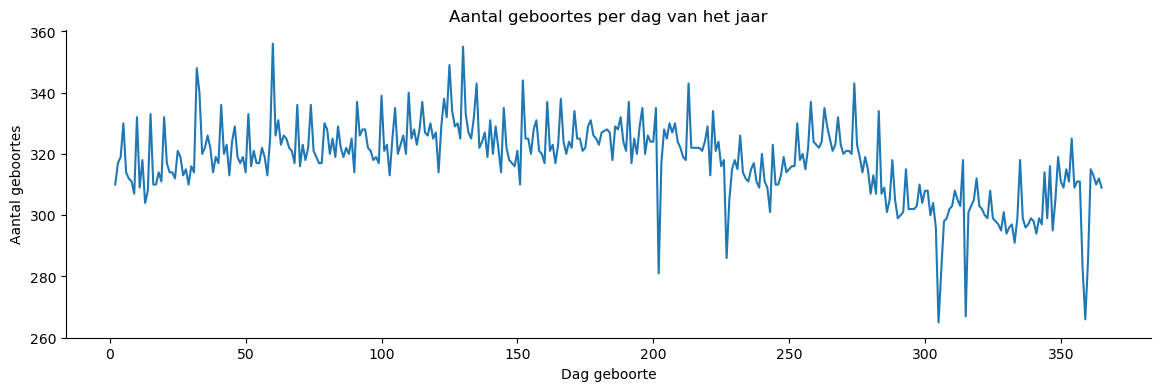

In [12]:
# Grouping by 'dag van het jaar' and counting the number of occurrences
births_per_day_cleaned = (births_xtracols_cleaned_df
                  .groupby('dag_geboorte')
                  .size())

# Create a lineplot without 1 januari and 1 july
lineplot(births_per_day_cleaned,
         title='Aantal geboortes per dag van het jaar',
         x_label='Dag geboorte',
         y_label='Aantal geboortes',
         set_ylim=260)

 We zien dat er nog steeds redelijk wat uitschieters zijn, kan je code schrijven om de 8 extreme uitschieters in de 2e helft van het jaar identificeren?

In [13]:
other_outliers = calculate_other_outliers(births_xtracols_cleaned_df)

other_outliers

,datum_geboorte,aantal geboortes
0,2019-07-21,281
1,2019-08-15,286
2,2019-11-01,265
3,2019-11-02,282
4,2019-11-11,267
5,2019-12-24,283
6,2019-12-25,266
7,2019-12-26,285


### Bonusvraag: wekelijkse verbanden

We zien vele pieken en dalen in de evolutie van het aantal geboortes. We willen deze grafiek graag iets "gladder" maken. Kan je hiervoor eens een visualizatie maken van het **gemiddeld** aantal geboortes per week (dit voor elke week, dus maandag-maandag, dinsdag-dinsdag, woensdag-woensdag, ...).

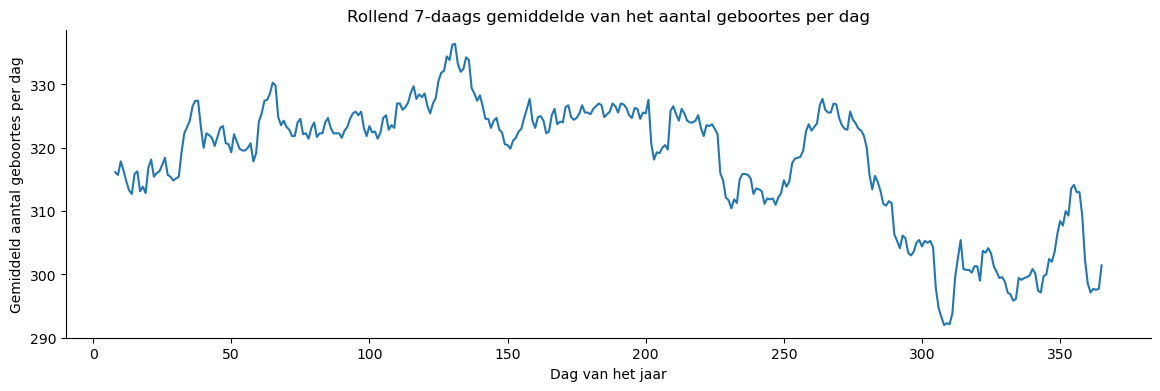

In [14]:
# Set 'dag geboorte' as the index without using inplace=True
births_xtracols_cleaned_rolling = births_per_day_cleaned.rolling(window=7, min_periods=1).mean()

# Omit the first 6 days -> rolling mean will be too low because less than 7 days are in it!
births_xtracols_cleaned_rolling = births_xtracols_cleaned_rolling.iloc[6:]

# Plot the rolling sum
lineplot(births_xtracols_cleaned_rolling,
         title='Rollend 7-daags gemiddelde van het aantal geboortes per dag',
         x_label='Dag van het jaar',
         y_label='Gemiddeld aantal geboortes per dag',
         set_ylim=290)

Dat ziet er al een stuk mooier uit!  We zien ook een aantal duidelijk dips & pieken verschijnen die we eerder niet zagen. We kunnen nu ook even kijken naar het gemiddeld aantal geboortes per dag van de week! Misschien worden er wel gewoon veel minder mensen geboren op zondag dan een andere dag?

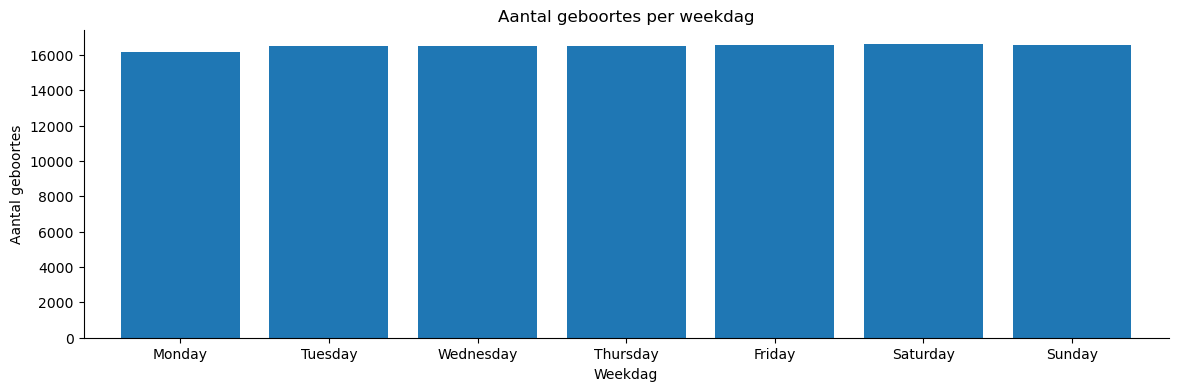

In [15]:
# Define the desired order of the days of the week
desired_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Calculate total births for each day of the week
births_per_weekday = (births_xtracols_cleaned_df
                      .groupby("weekdag_geboorte")
                      .size()
                      .reindex(desired_order))

barplot(births_per_weekday, 
        title='Aantal geboortes per weekdag',
        x_label='Weekdag',
        y_label='Aantal geboortes',
        width=0.8)

In [16]:
births_xtracols_cleaned_df

,gemeente,naam,geslacht,datum_verwacht,datum_geboorte,weekdag_verwacht,weekdag_geboorte,dag_verwacht,dag_geboorte,verschil
534,Sint-Agatha-Berchem,Isabelle,Vrouwelijk,2019-02-22,2019-01-02,Friday,Wednesday,53,2,-51
535,Tremelo,Magdalena,Vrouwelijk,2019-01-28,2019-01-02,Monday,Wednesday,28,2,-26
536,Aalst (Aalst),Ann,Vrouwelijk,2019-01-07,2019-01-02,Monday,Wednesday,7,2,-5
537,Zonhoven,Christophe,Mannelijk,2019-01-01,2019-01-02,Tuesday,Wednesday,1,2,1
538,Wezet,Gabriel,Mannelijk,2018-12-28,2019-01-02,Friday,Wednesday,362,2,5
...,...,...,...,...,...,...,...,...,...,...
116845,Balen,Ronny,Mannelijk,2019-12-30,2019-12-31,Monday,Tuesday,364,365,1
116846,Mechelen,Sanae,Vrouwelijk,2020-01-05,2019-12-31,Sunday,Tuesday,5,365,-5
116847,Blankenberge,Steve,Mannelijk,2019-12-27,2019-12-31,Friday,Tuesday,361,365,4
116848,Kalmthout,Dirk,Mannelijk,2020-01-25,2019-12-31,Saturday,Tuesday,25,365,-25


# Examen Python Data Developer
# Deel 2

Ga verder met de verwerkte data die je uit deel 1 hebt. We gaan nu op basis van dezelfde dataset een aantal onderzoeksvragen oplossen!

### Onderzoek 1: Unisex namen
#### Een aantal statistieken
Sommige namen zijn unisex, dat wil zeggen dat zij hetzelfde zijn voor mannen en vrouwen. Beantwoord volgende 3 vragen over unisex namen in onze dataset:
 - Hoeveel unisex namen zijn er?
 - Wat is de meest voorkomende unisex naam; hiervoor zoek ik 3 namen (en getallen):
    - De meest populaire unisex naam bij mannen.
    - De meest populaire unisex naam bij vrouwen.
    - De meest popuaire unisex naam.

**Tip:** Neem hiervoor terug de volledige dataset in acht (dus met de foutief geklasseerde namen).

In [17]:
# Group by 'naam' and 'geslacht' and count occurrences
count_geslacht = births_df_raw.groupby(['naam', 'geslacht']).size()

# Get the index level values of 'naam' where duplicates occur
duplicated_naam_index = count_geslacht[count_geslacht.index.get_level_values('naam').duplicated()].index

# Extract the unique 'naam' values from the index
unique_naam_values = duplicated_naam_index.get_level_values('naam').unique()

# Reset index to make 'naam' and 'geslacht' regular columns
count_geslacht = count_geslacht.reset_index()

# Filter for 'naam' values with more than one 'geslacht'
multi_geslacht_df = count_geslacht[count_geslacht['naam'].isin(unique_naam_values)]

# Rename the '0' column to 'aantal'
multi_geslacht_df = multi_geslacht_df.rename(columns={0: 'aantal'})

multi_geslacht_df

,naam,geslacht,aantal
75,Adama,Mannelijk,1
76,Adama,Vrouwelijk,3
197,Alexis,Mannelijk,68
198,Alexis,Vrouwelijk,1
274,Amel,Mannelijk,1
...,...,...,...
5192,Yentl,Vrouwelijk,7
5194,Yi,Mannelijk,1
5195,Yi,Vrouwelijk,1
5209,Yoni,Mannelijk,3


In [18]:
# Filter DataFrame for 'Mannelijk' and 'Vrouwelijk'
mannelijk_df = multi_geslacht_df[multi_geslacht_df['geslacht'] == 'Mannelijk']
vrouwelijk_df = multi_geslacht_df[multi_geslacht_df['geslacht'] == 'Vrouwelijk']

# Sort both DataFrames by the 'aantal' column in descending order
sorted_mannelijk_df = mannelijk_df.sort_values(by='aantal', ascending=False)
sorted_vrouwelijk_df = vrouwelijk_df.sort_values(by='aantal', ascending=False)

# Print the sorted DataFrames
print("Sorted DataFrame for Mannelijk:")
print(sorted_mannelijk_df[['naam', 'geslacht', 'aantal']])

print("\nSorted DataFrame for Vrouwelijk:")
print(sorted_vrouwelijk_df[['naam', 'geslacht', 'aantal']])

Sorted DataFrame for Mannelijk:
           naam   geslacht  aantal
3407     Maxime  Mannelijk     203
4258      Robin  Mannelijk     185
962      Claude  Mannelijk     167
1172  Dominique  Mannelijk     161
2507       José  Mannelijk     142
...         ...        ...     ...
1211     Dursun  Mannelijk       1
642        Beau  Mannelijk       1
332      Andréa  Mannelijk       1
274        Amel  Mannelijk       1
2863     Leslie  Mannelijk       1

[75 rows x 3 columns]

Sorted DataFrame for Vrouwelijk:
           naam    geslacht  aantal
1173  Dominique  Vrouwelijk     233
805     Camille  Vrouwelijk     163
2689        Kim  Vrouwelijk     114
3856       Noor  Vrouwelijk      67
4624     Simone  Vrouwelijk      67
...         ...         ...     ...
2186      Imran  Vrouwelijk       1
4159      Rayan  Vrouwelijk       1
2254      Islam  Vrouwelijk       1
2398      Jente  Vrouwelijk       1
1611       Flor  Vrouwelijk       1

[75 rows x 3 columns]


In [19]:
num_unique_naam = multi_geslacht_df['naam'].nunique()
print("Aantal namen met zowel 'Mannelijk' als 'Vrouwelijk' voor 'Geslacht':", num_unique_naam)

Aantal namen met zowel 'Mannelijk' als 'Vrouwelijk' voor 'Geslacht': 75


In [20]:
most_popular_name_and_count(multi_geslacht_df)

Populairste echte unisex naam bij de mannen: Maxime ; Aantal: 203
Populairste echte unisex naam bij de vrouwen: Dominique ; Aantal: 233
Populairste unisex naam in het algemeen: 436


We zien dat er een vrij groot aantal namen veel meer voorkomen bij mannen dan vrouwen (en omgekeerd). Dit vinden we eigenlijk geen "echte" unisex namen. We noemen een naam "echt unisex" als de naam niet meer dan 50% meer voorkomt bij 1 van de 2 geslachten. Dus als er `x` mannen en `y` vrouwen zijn genaamd Chris, dan noemen we Chris "echt unisex" als `x <= 1.5 * y` en `y <= x * 1.5`. Filter je unisex dataframe tot een `df_real_unisex` waarbij je enkel de "echte" unisex namen weerhoudt. 
- Beantwoord nu bovenstaande 3 vragen opnieuw voor deze dataset. Hierbij werk je best met een functie zodat je geen code moet herhalen!
- Zijn de echte unisex namen populairder bij mannen of vrouwen, of is de populariteit hetzelfde? Deze vraag kan je beantwoorden door te kijken naar het percentage mannen/vrouwen met een echte unisex naam.

In [21]:
# Group by 'naam' and 'geslacht' to calculate counts
grouped = multi_geslacht_df.groupby(['naam', 'geslacht']).sum().unstack(fill_value=0)

# Filter names where the number of occurrences for one gender is at least 1.5 times greater than the other
unbalanced_names = grouped[(grouped['aantal', 'Mannelijk'] >1.5 * grouped['aantal', 'Vrouwelijk']) & 
                           (grouped['aantal', 'Vrouwelijk'] >1.5 * grouped['aantal', 'Mannelijk'])]

# Extract the names from the index
unbalanced_names = unbalanced_names.index.tolist()

# Filter the DataFrame to include only "real" unisex names
df_real_unisex = multi_geslacht_df[~multi_geslacht_df['naam'].isin(unbalanced_names)]

df_real_unisex.reset_index()

,index,naam,geslacht,aantal
0,75,Adama,Mannelijk,1
1,76,Adama,Vrouwelijk,3
2,197,Alexis,Mannelijk,68
3,198,Alexis,Vrouwelijk,1
4,274,Amel,Mannelijk,1
...,...,...,...,...
145,5192,Yentl,Vrouwelijk,7
146,5194,Yi,Mannelijk,1
147,5195,Yi,Vrouwelijk,1
148,5209,Yoni,Mannelijk,3


In [22]:
most_popular_name_and_count(df_real_unisex)

Populairste echte unisex naam bij de mannen: Maxime ; Aantal: 203
Populairste echte unisex naam bij de vrouwen: Dominique ; Aantal: 233
Populairste unisex naam in het algemeen: 436


## IK HEB HET STUK HIERONDER NOG NIET WERKEND GEKREGEN... Vanaf vraag 2 wel...

In [23]:
# Count the total number of men with unisex names in df_real_unisex
men_with_unisex_names = df_real_unisex[df_real_unisex['geslacht'] == 'Mannelijk']['naam'].nunique()

# Count the total number of men in births_df_raw
total_men = births_df_raw[births_df_raw['geslacht'] == 'Mannelijk']['naam'].nunique()

# Calculate the percentage of men with unisex names compared to all men
percentage_men_with_unisex = men_with_unisex_names / total_men

# Count the total number of women with unisex names in df_real_unisex
women_with_unisex_names = df_real_unisex[df_real_unisex['geslacht'] == 'Vrouwelijk']['naam'].nunique()

# Count the total number of women in births_df_raw
total_women = births_df_raw[births_df_raw['geslacht'] == 'Vrouwelijk']['naam'].nunique()

# Calculate the percentage of women with unisex names compared to all women
percentage_women_with_unisex = women_with_unisex_names / total_women

# Print the results using the utility function
print("Percentage mannen met unisex naam:", to_percentage(percentage_men_with_unisex))
print("Percentage vrouwen met unisex naam:", to_percentage(percentage_women_with_unisex))

Percentage mannen met unisex naam: 2.97%
Percentage vrouwen met unisex naam: 2.67%


output:
- Percentage mannen met unisex naam: 0.4%
- Percentage vrouwen met unisex naam: 0.5%

#### Visualizatie

Maak een visualizatie die alle echte unisex namen toont en de relatieve voorkomens bij mannen en vrouwen..

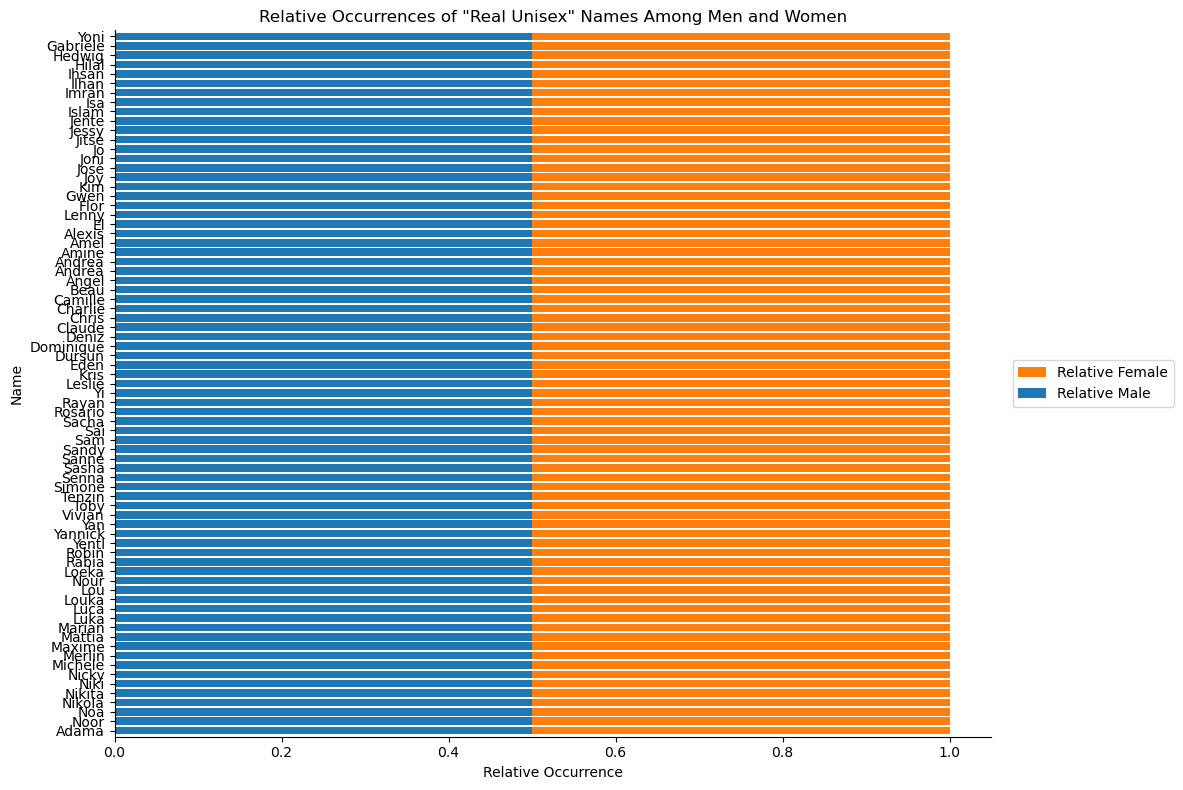

In [24]:
# Calculate the total counts of each name for both genders
name_counts = df_real_unisex.groupby(['naam', 'geslacht']).size().unstack(fill_value=0)

# Calculate the total counts for each name
total_counts = name_counts.sum(axis=1)

# Calculate the relative occurrences for men and women
name_counts['Relative Male'] = name_counts['Mannelijk'] / total_counts
name_counts['Relative Female'] = name_counts['Vrouwelijk'] / total_counts

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), gridspec_kw={'width_ratios': [9, 1]})

# Plot the relative occurrences for each name
name_counts[['Relative Male', 'Relative Female']].sort_values(by='Relative Male').plot(kind='barh', stacked=True, width=0.8, ax=ax1)
ax1.set_title('Relative Occurrences of "Real Unisex" Names Among Men and Women')
ax1.set_xlabel('Relative Occurrence')
ax1.set_ylabel('Name')

# Remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Hide the ticks for the legend subplot
ax2.axis('off')

# Remove legend from the left plot
ax1.legend_.remove()

# Create a legend for the right subplot
handles, labels = ax1.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], loc='center')

plt.tight_layout()
plt.show()

### Onderzoek 2: de accuraatheid van de geschatte bevallingsdatum
#### Evolutie vergelijken

Maak een afbeelding van het totaal aantal geboortes per dag en het totaal aantal verwachte geboortes.

**Bonusvraag**: Gewoon om over na te denken: waarom zien de uiteindes van je plot er wat gek uit? Schrijf het antwoord neer in een strategisch geplaatste markdown cel.

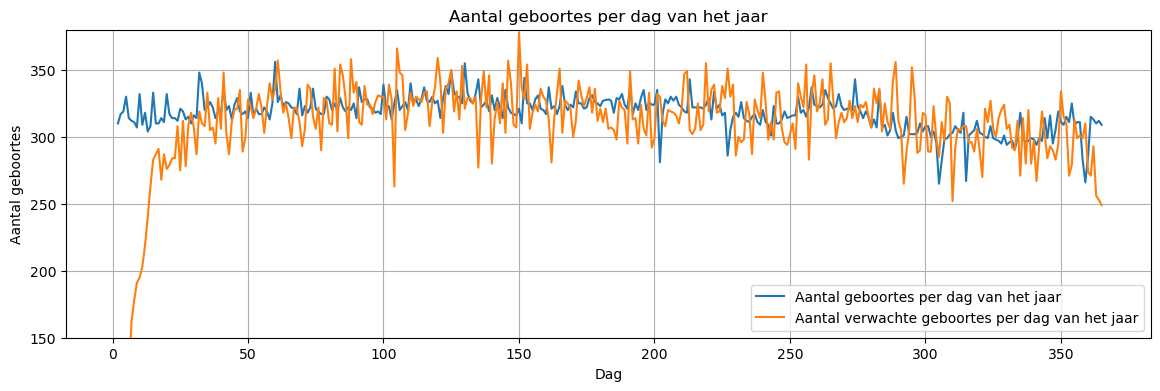

In [25]:
# Filter the DataFrame for rows where both dates are in the year 2019
filtered_2019_df = births_xtracols_cleaned_df.loc[
    (births_xtracols_cleaned_df['datum_verwacht'].dt.year == 2019) & 
    (births_xtracols_cleaned_df['datum_geboorte'].dt.year == 2019)
].copy()

def lineplot(data1, data2, title='', x_label='', y_label='', set_ylim=None):
    plt.figure(figsize=(14, 4))
    plt.plot(data1, label='Aantal geboortes per dag van het jaar')
    plt.plot(data2, label='Aantal verwachte geboortes per dag van het jaar')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if set_ylim is not None:
        plt.ylim(set_ylim)
    plt.legend()
    plt.grid(True)
    plt.show()

# Grouping by 'dag van het jaar' and counting the number of occurrences
births_per_day_cleaned = births_xtracols_cleaned_df.groupby('dag_geboorte').size()
births_per_day_expected = filtered_2019_df.groupby('dag_verwacht').size()

# Create a line plot with both actual and expected births per day
lineplot(births_per_day_cleaned, births_per_day_expected, title='Aantal geboortes per dag van het jaar', x_label='Dag', y_label='Aantal geboortes', set_ylim=(150, 380))

Bonusvraag: De uiteindes van de grafiek zien er gek uit omdat:
- De blauwe lijn stelt elke geboorte dag van het jaar voor, op elke dag van 2019 (elk .csv bestand was 1 dag)
- De oranje lijn stelt elke verwachte dag van het jaar voor waarvan de geboortedag in 2019 viel. Er zitten dus ook baby's in de dataset waarbij de verwachte datum in 2018 of 2020 ligt. Aangezien (zie volgende grafiek) het verschil in dagen tussen werkelijke en verwachte geboortedata niet gecentreerd ligt rond 0, zal het effect aan de linkerzijde groter zijn dan aan de rechterzijde.

#### Verbanden bekijken
Maak een histogram van het aantal dagen dat babies te vroeg geboren werden in 2019 en een scatterplot die het verband toont tussen de verwachte en effectieve geboortedatum.

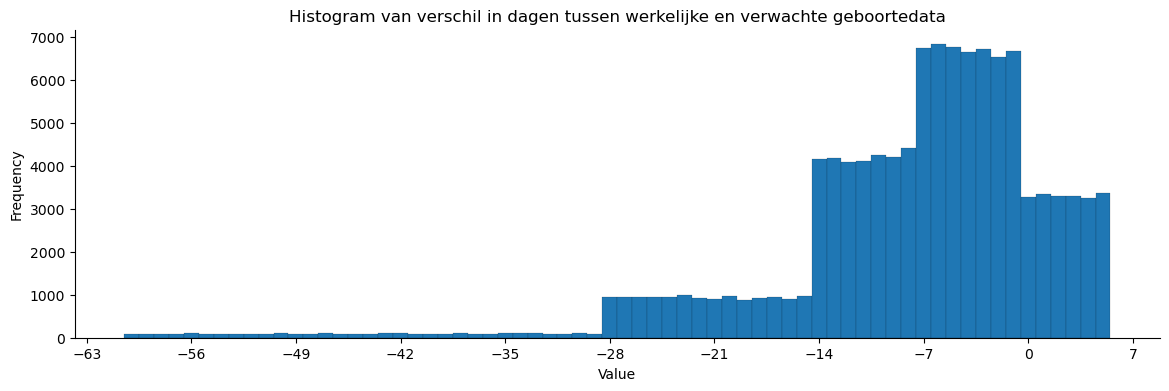

In [26]:
histogram_plot(data=births_xtracols_cleaned_df['verschil'], 
               title="Histogram van verschil in dagen tussen werkelijke en verwachte geboortedata", 
               x_label="Value",
               y_label="Frequency", 
               num_bins=np.arange(births_xtracols_cleaned_df['verschil'].min() - 0.5, births_xtracols_cleaned_df['verschil'].max() + 0.5),
               xticks=np.arange(7, births_xtracols_cleaned_df['verschil'].min()-7, -7))

In plaats van een scatterplot kies ik voor een hexbin plot: We hebben we maken met een grote dataset, waardoor vele scatter punten op elkaar zullen vallen. Met hexbin kan je in klassen werken. Zoals je kan zien stelt een gele hex een combinatie voor die meer dan 250 keer voorkomt!

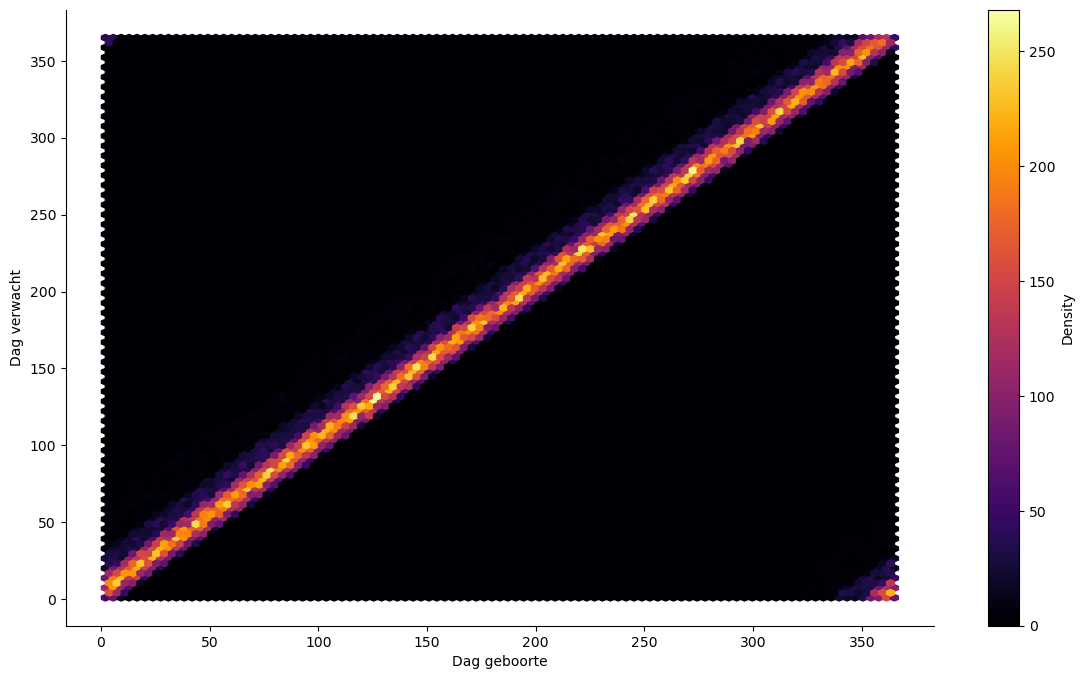

In [27]:
fig, ax = plt.subplots(figsize=(14, 8))
hb = ax.hexbin(births_xtracols_cleaned_df['dag_geboorte'],
               births_xtracols_cleaned_df['dag_verwacht'],
               gridsize=100, cmap='inferno')
ax.set_xlabel('Dag geboorte')
ax.set_ylabel('Dag verwacht')
cb = fig.colorbar(hb)
cb.set_label('Density')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Onderzoek 3: Aantal namen versus aantal babies
Naarmate dat er meer babies geboren worden, gaan deze ook meer verschillende namen krijgen. Zolang er weinig babies geboren worden lijkt het logisch dat dit verband min of meer lineair is, maar naarmate dat er meer en meer babies geboren worden lijkt het niet meer logisch dat dit verband lineair blijft. We verwachten bijvoorbeeld niet dat het aantal unieke namen gegeven aan 2 miljoen babies het dubbel is van het aantal unieke namen gegeven aan 1 miljoen babies. Kan je op basis van deze dataset het verband tussen het aantal unieke namen in functie van het aantal babies eens onderzoeken? Hiervoor krijg je geen voorstel tot visualizatie maar moet je zelf mij proberen te overtuigen van je antwoord.

#### Onderzoekje 3.1: Meest voorkomende namen 

Het aantal unieke namen: 5237
Het percentage unieke namen: 4.54%
Het aantal namen dat slechts één keer voorkomt: 1805


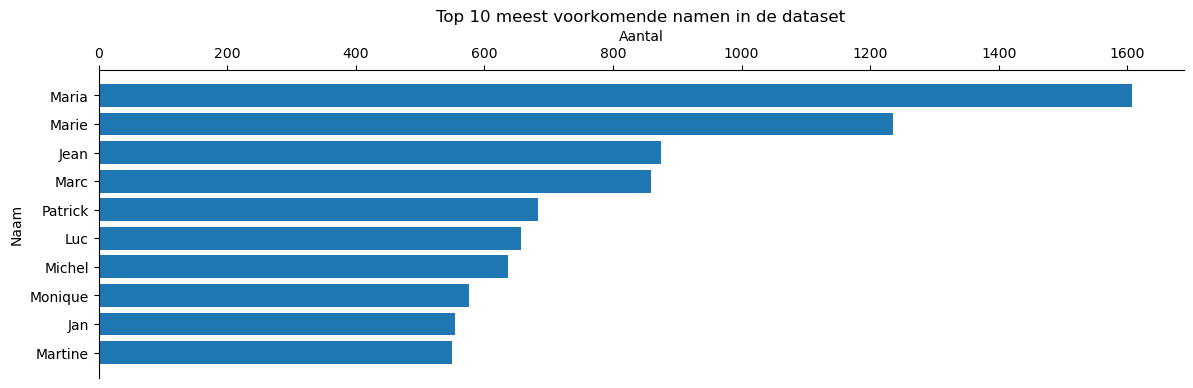

In [28]:
# Count occurrences of each name
name_counts = births_xtracols_cleaned_df['naam'].value_counts()

num_unique_names = len(name_counts)
total_names = len(births_xtracols_cleaned_df)  # total number of names
percentage_unique_names = to_percentage(num_unique_names / total_names)
number_of_names_once = np.sum(name_counts == 1)

print("Het aantal unieke namen:", num_unique_names)
print("Het percentage unieke namen:", percentage_unique_names)
print("Het aantal namen dat slechts één keer voorkomt:", number_of_names_once)

# Select the top 10 most common names
top_names = name_counts.head(10)

# Plot horizontal bar plot
horizontal_bar_plot(data=top_names, 
                    title="Top 10 meest voorkomende namen in de dataset", 
                    x_label="Aantal", 
                    y_label="Naam")

#### Onderzoekje 3.2: Simulatie

In [29]:
# Sample sizes
sample_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]

# Number of simulations
num_simulations = 100

# Results storage
average_unique_names_counts = []

# Perform simulations for each sample size
for sample_size in sample_sizes:
    # Results storage for current sample size
    unique_names_counts = []
    
    # Perform simulations
    for _ in range(num_simulations):
        unique_names_count = compute_num_unique(births_xtracols_cleaned_df, sample_size)
        unique_names_counts.append(unique_names_count)
    
    # Calculate the average for current sample size
    average_unique_names_count = np.mean(unique_names_counts)
    average_unique_names_counts.append(average_unique_names_count)

# Create DataFrame for results
results_df = pd.DataFrame({"Steekproefgrootte": sample_sizes, "Gemiddeld aantal unieke namen": average_unique_names_counts})

print(results_df)

   Steekproefgrootte  Gemiddeld aantal unieke namen
0                100                          91.85
1                200                         172.05
2                500                         364.16
3               1000                         596.90
4               2000                         918.42
5               5000                        1477.94
6              10000                        2027.17
7              20000                        2708.82
8              50000                        3878.42
9             100000                        4984.79


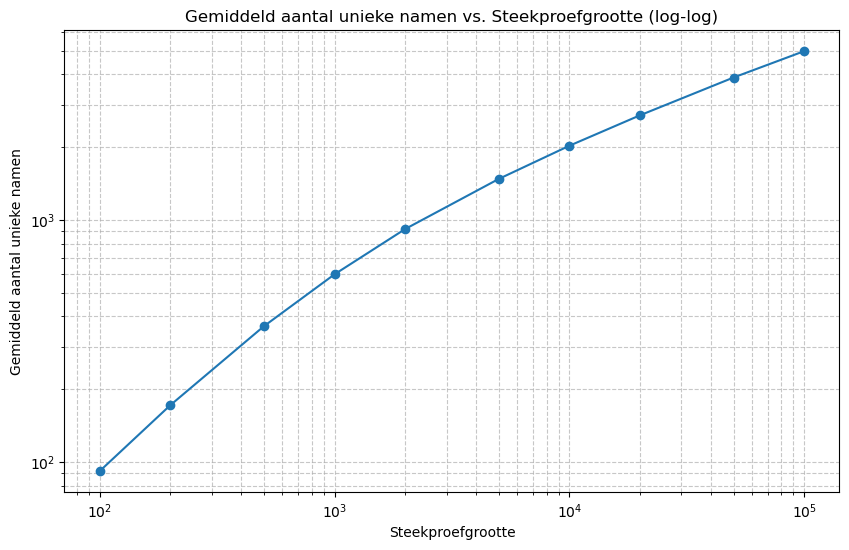

In [30]:
# Plot the results in a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(results_df["Steekproefgrootte"], results_df["Gemiddeld aantal unieke namen"], marker='o')
plt.title("Gemiddeld aantal unieke namen vs. Steekproefgrootte (log-log)")
plt.xlabel("Steekproefgrootte")
plt.ylabel("Gemiddeld aantal unieke namen")
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.show()

Door deze grafiek te extrapoleren kan je een idee krijgen hoeveel gemiddeld aantal unieke namen er zullen zijn bij een groep van 10^6, 10^7,... baby's.

#### Onderzoekje 3.3a: CDF van namen op normale schaal

In [31]:
# Compute the number of occurrences for each name
name_counts = births_xtracols_cleaned_df['naam'].value_counts()

# Calculate the cumulative distribution of occurrence frequencies
cdf_values = np.cumsum(name_counts.values) / np.sum(name_counts.values)

# Get the ranks of names
ranks = np.arange(1, len(name_counts) + 1)

# Find the rank where CDF crosses 0.5
rank_cross_50 = np.argmax(cdf_values >= 0.5) + 1  # Add 1 to convert index to rank
print("De rang van de naam waar de cumulatieve verdelingsfunctie 0.5 overschrijdt:", rank_cross_50)

De rang van de naam waar de cumulatieve verdelingsfunctie 0.5 overschrijdt: 225


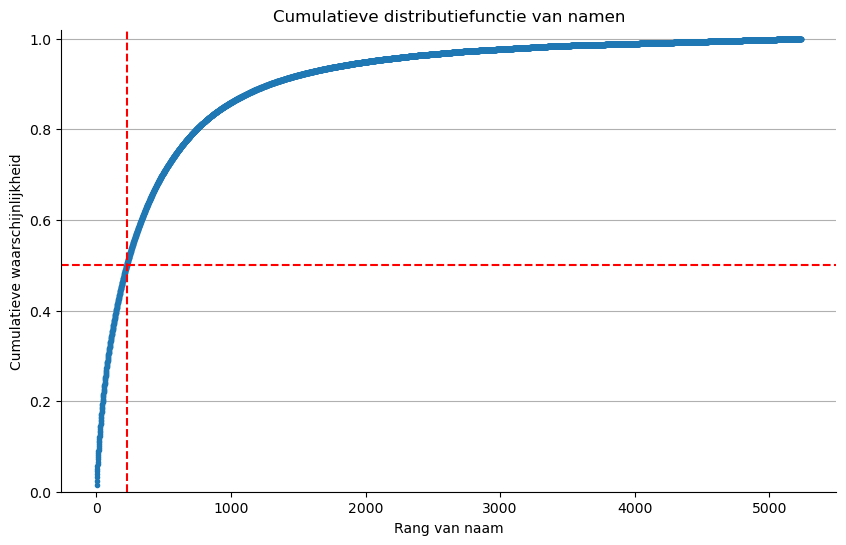

In [32]:
# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(ranks, cdf_values, marker='.', linestyle='-')
plt.title('Cumulatieve distributiefunctie van namen')
plt.xlabel('Rang van naam')
plt.ylabel('Cumulatieve waarschijnlijkheid')
plt.grid(axis='y')  # Only show horizontal gridlines
plt.ylim(0, 1.02)
plt.gca().spines['top'].set_visible(False)  # Hide top spine
plt.gca().spines['right'].set_visible(False)  # Hide right spine
plt.axhline(y=0.5, color='red', linestyle='--')
plt.axvline(x=rank_cross_50, color='red', linestyle='--')
plt.show()

#### Onderzoekje 3.3b: CDF van namen op log-log schaal

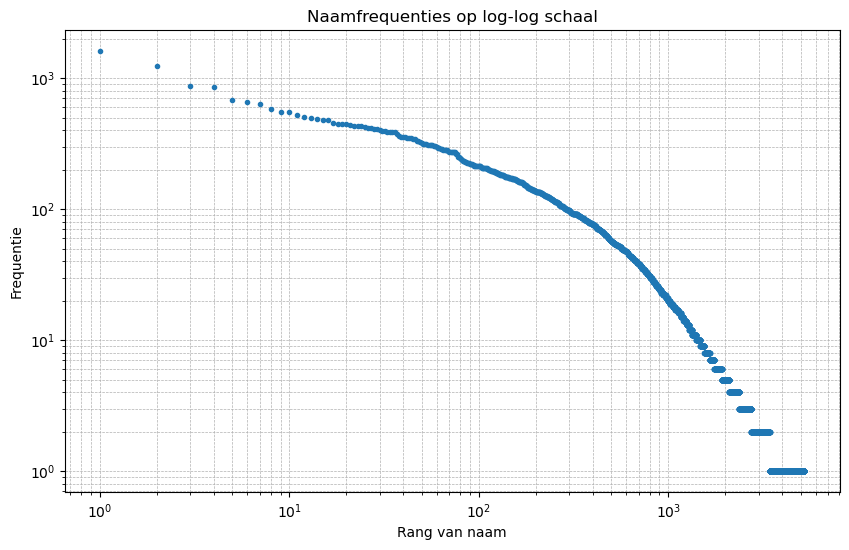

In [33]:
name_counts = births_xtracols_cleaned_df['naam'].value_counts()

# Get the ranks of names
ranks = np.arange(1, len(name_counts) + 1)

# Plot the name frequencies on a log-log scale
plt.figure(figsize=(10, 6))
plt.plot(ranks, name_counts.values, marker='.', linestyle='none')
plt.title('Naamfrequenties op log-log schaal')
plt.xlabel('Rang van naam')
plt.ylabel('Frequentie')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

Constatering: Vooral bij veel voorkomende namen (>10^2) zien we iets wat lijkt op een lineaire trend

#### Onderzoekje 3.3c: log-kolommen toevoegen aan dataframe

In [34]:
# Groepeer op "naam" en tel het aantal records
name_counts = births_xtracols_cleaned_df.groupby('naam').size()

# Filter records waar "naam" minstens 100 keer voorkomt
name_counts = name_counts[name_counts >= 200]

# Rangschik de tellingen van "naam" van groot naar klein
name_counts = name_counts.sort_values(ascending=False)

# Maak een nieuw DataFrame met de naam en de tellingen van "naam"
new_df = pd.DataFrame({'naam': name_counts.index, 'count': name_counts.values})

# Voeg een kolom "index" toe aan het nieuwe DataFrame
new_df['index'] = range(1, len(new_df) + 1)

# Voeg nieuwe kolommen toe voor log(count) en log(index)
new_df['log(count)'] = np.log(new_df['count'])
new_df['log(index)'] = np.log(new_df['index'])

# Toon het nieuwe DataFrame
new_df

,naam,count,index,log(count),log(index)
0,Maria,1607,1,7.382124,0.000000
1,Marie,1235,2,7.118826,0.693147
2,Jean,874,3,6.773080,1.098612
3,Marc,859,4,6.755769,1.386294
4,Patrick,684,5,6.527958,1.609438
...,...,...,...,...,...
109,Elisabeth,205,110,5.323010,4.700480
110,Godelieve,204,111,5.318120,4.709530
111,Francis,202,112,5.308268,4.718499
112,Bruno,200,113,5.298317,4.727388


Nu kunnen we mbv lineaire interpolatie zoeken naar het verband! Merk op dat de R^2 van de trendlijn best hoog is. Op basis van de trendlijn kunnen we inschatten wat de count van het aantal namen zal zijn, gegeven welke rank die naam heeft als je de namen rangschikt van groot naar klein.

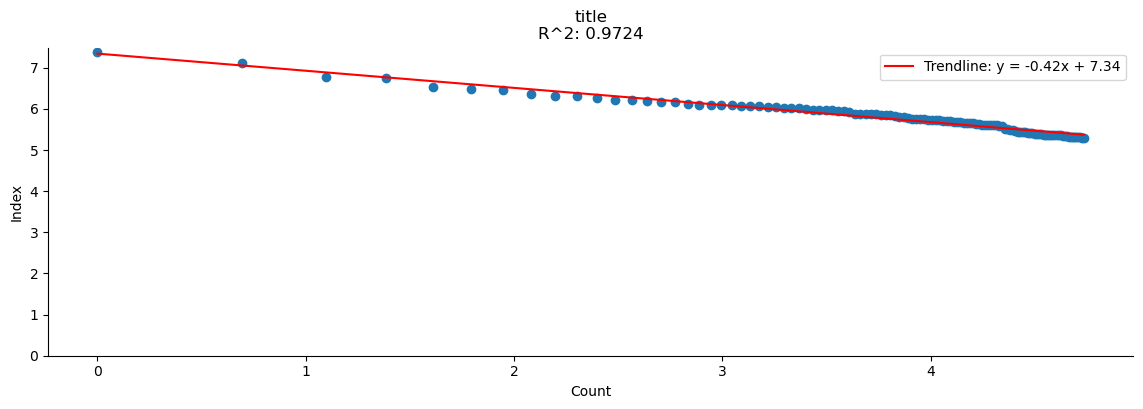

In [35]:
def scatterplot(data, title, x_label, y_label, set_ylim, x_column='count', y_column='index'):
    """
    Function to create a simple scatter plot with trendline.
    """
    plt.figure(figsize=(14, 4))
    plt.scatter(data[x_column], data[y_column], color='C0')

    # Fit a polynomial regression line
    coefficients = np.polyfit(data[x_column], data[y_column], 1)
    polynomial = np.poly1d(coefficients)
    trendline_x = np.linspace(data[x_column].min(), data[x_column].max(), 100)
    trendline_y = polynomial(trendline_x)
    plt.plot(trendline_x, trendline_y, color='red', label=f'Trendline: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')

    # Calculate R^2 value manually
    mean_y = np.mean(data[y_column])
    total_sum_of_squares = np.sum((data[y_column] - mean_y) ** 2)
    sum_of_squared_residuals = np.sum((data[y_column] - polynomial(data[x_column])) ** 2)
    r_squared = 1 - (sum_of_squared_residuals / total_sum_of_squares)

    # Customize the axes
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set the title and labels
    plt.title(f"{title}\nR^2: {r_squared:.4f}")
    plt.xlabel(x_label, rotation=0)
    plt.ylabel(y_label)

    # Set y-axis limits
    plt.ylim(set_ylim)

    # Show legend
    plt.legend()

    plt.show()

# Call the scatterplot function with the given data, specifying the columns to plot
scatterplot(new_df, title="title", x_label="Count", y_label="Index", set_ylim=(0, None), x_column='log(index)', y_column='log(count)')